# Project 1: Navigation
### Test 1 - DQN model

<sub>Uirá Caiado. August 24, 2018<sub>

#### Abstract


_In this notebook, I will use the Unity ML-Agents environment to train a DQN model for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)._

## 1. What we are going to test

Bla bla .... Thus, let's begin by checking the environment where I am going to run these tests.

In [1]:
%load_ext version_information
%version_information numpy, unityagents, torch, matplotlib, pandas, gym

Software versions
Python 3.6.6 64bit [GCC 7.2.0]
IPython 6.5.0
OS Linux 4.4.0 1060 aws x86_64 with debian stretch sid
numpy 1.15.1
unityagents 0.4.0
torch 0.4.0
matplotlib 2.2.3
pandas 0.23.4
gym 0.10.5
Fri Aug 24 05:17:09 2018 UTC

Now, let's define some meta variables to use in this notebook

In [2]:
import os
fig_prefix = 'figures/2018-08-24-'
data_prefix = '../data/2018-08-24-'
s_currentpath = os.getcwd()

Also, let's import some of the necessary packages for this experiment.

In [3]:
from unityagents import UnityEnvironment
import sys
import os
sys.path.append("../")  # include the root directory as the main
import eda
import pandas as pd
import numpy as np

## 2. Training the agent

The environment used for this project is the Udacity version of the Banana Collector environment, from [Unity](https://youtu.be/heVMs3t9qSk). The goal of the agent is to collect as many yellow bananas as possible while avoiding blue bananas. Bellow, we are going to start this environment.

In [4]:
env = UnityEnvironment(file_name="../Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Unity Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

Now, we are going to collect some basic information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)

And finally, we are going to train the model. We will consider that this environment is solved if the agent is able to receive an average reward (over 100 episodes) of at least +13.

In [7]:
%%time

import gym
import pickle
import random
import torch
import numpy as np
from collections import deque
from drlnd.dqn_agent import DQNAgent, DDQNAgent, DDQNPREAgent

n_episodes = 2000
eps_start = 1.
eps_end=0.01
eps_decay=0.995
max_t = 1000
s_model = 'dqn'

agent = DQNAgent(state_size=state_size, action_size=action_size, seed=0)

scores = []                        # list containing scores from each episode
scores_std = []                    # List containing the std dev of the last 100 episodes
scores_avg = []                    # List containing the mean of the last 100 episodes
scores_window = deque(maxlen=100)  # last 100 scores
eps = eps_start                    # initialize epsilon

for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    for t in range(max_t):
        # action = np.random.randint(action_size)        # select an action
        action = agent.act(state, eps)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        agent.step(state, action, reward, next_state, done)
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    scores_std.append(np.std(scores_window)) # save most recent std dev
    scores_avg.append(np.mean(scores_window)) # save most recent std dev
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window)>=13.0:
        s_msg = '\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
        print(s_msg.format(i_episode, np.mean(scores_window)))
        torch.save(agent.qnet.state_dict(), '%scheckpoint_%s.pth' % (data_prefix, s_model))
        break
        
# save data to use latter
d_data = {'episodes': i_episode,
          'scores': scores,
          'scores_std': scores_std,
          'scores_avg': scores_avg,
          'scores_window': scores_window}
pickle.dump(d_data, open('%ssim-data-%s.data' % (data_prefix, s_model), 'wb'))

Episode 100	Average Score: 0.64
Episode 200	Average Score: 4.20
Episode 300	Average Score: 6.82
Episode 400	Average Score: 10.69
Episode 500	Average Score: 12.40
Episode 529	Average Score: 13.01
Environment solved in 529 episodes!	Average Score: 13.01
CPU times: user 5min 41s, sys: 15.1 s, total: 5min 56s
Wall time: 8min 6s


## 3. Results

The agent using the vanilla DQN was able to solve the Banana Collector environment in X episodes of 1000 steps, each.

In [8]:
import pickle

d_data = pickle.load(open('../data/2018-08-24-sim-data-dqn.data', 'rb'))
s_msg = 'Environment solved in {:d} episodes!\tAverage Score: {:.2f} +- {:.2f}'
print(s_msg.format(d_data['episodes'], np.mean(d_data['scores_window']), np.std(d_data['scores_window'])))

Environment solved in 529 episodes!	Average Score: 13.01 +- 3.42


Now, let's plot the rewards per episode. In the right panel, we will plot the rolling average score over 100 episodes $\pm$ its standard deviation, as well as the goal of this project (13+ on average over the last 100 episodes).

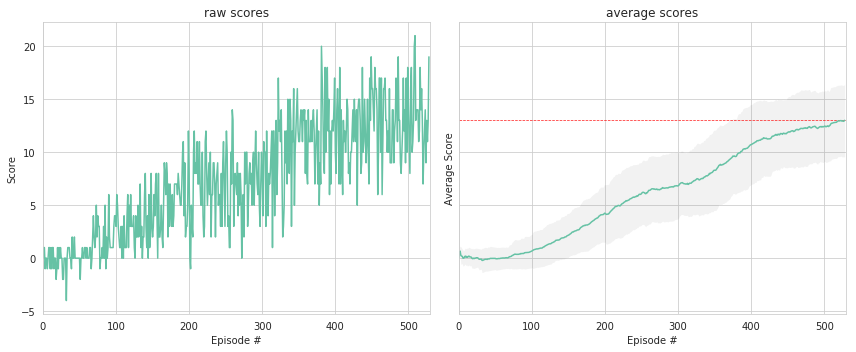

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

#recover data
na_raw = np.array(d_data['scores'])
na_mu = np.array(d_data['scores_avg'])
na_sigma = np.array(d_data['scores_std'])

# plot the scores
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# plot the sores by episode
ax1.plot(np.arange(len(na_raw)), na_raw)
ax1.set_xlim(0, len(na_raw)+1)
ax1.set_ylabel('Score')
ax1.set_xlabel('Episode #')
ax1.set_title('raw scores')

# plot the average of these scores
ax2.axhline(y=13., xmin=0.0, xmax=1.0, color='r', linestyle='--', linewidth=0.7, alpha=0.9)
ax2.plot(np.arange(len(na_mu)), na_mu)
ax2.fill_between(np.arange(len(na_mu)), na_mu+na_sigma, na_mu-na_sigma, facecolor='gray', alpha=0.1)
ax2.set_ylabel('Average Score')
ax2.set_xlabel('Episode #')
ax2.set_title('average scores')

f.tight_layout()

In [56]:
env.close()

## 4. Conclusion


This was the best implementation so far.... TODO